In [24]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    # 'stats_bb0': load_data('../stats/stats_bb0.json'),
    'stats_geo1x1_sol1_ph0_bb1_fr1': load_data('../stats/stats_geo1x1_sol1_ph0_bb1_fr1.json'),
    'stats_geo1x1_sol2_ph0_bb1_fr1': load_data('../stats/stats_geo1x1_sol2_ph0_bb1_fr1.json'),
    # 'stats_geo1x1_ph1_bb1_fr0': load_data('../stats/stats_ph1_bb1_fr0.json'),
}

shape = [3, 2]
figsize = (12, 5)

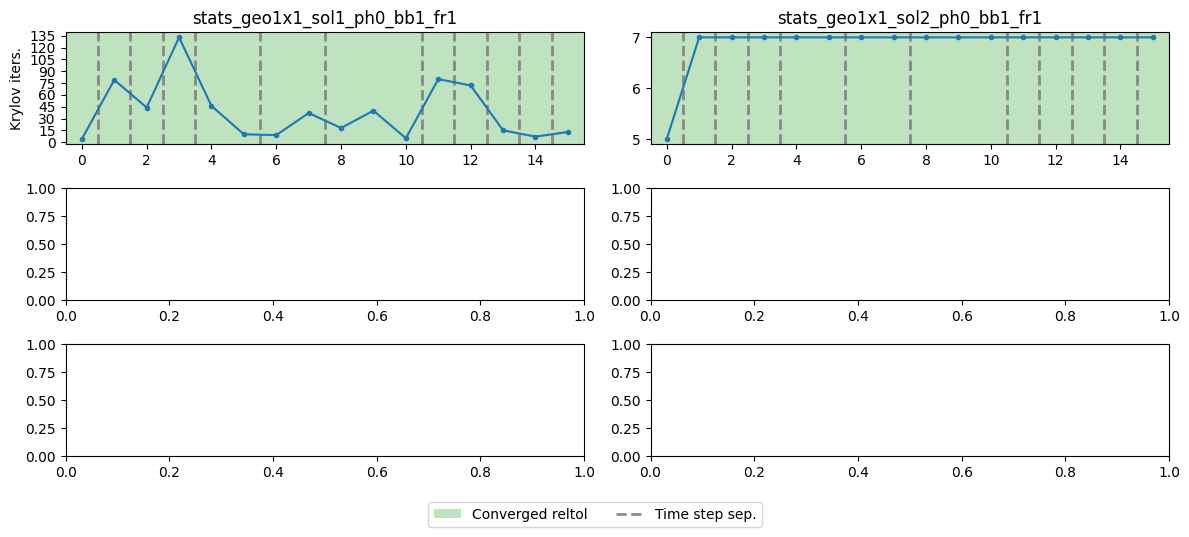

In [25]:
def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    set_integer_ticks('vertical')
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

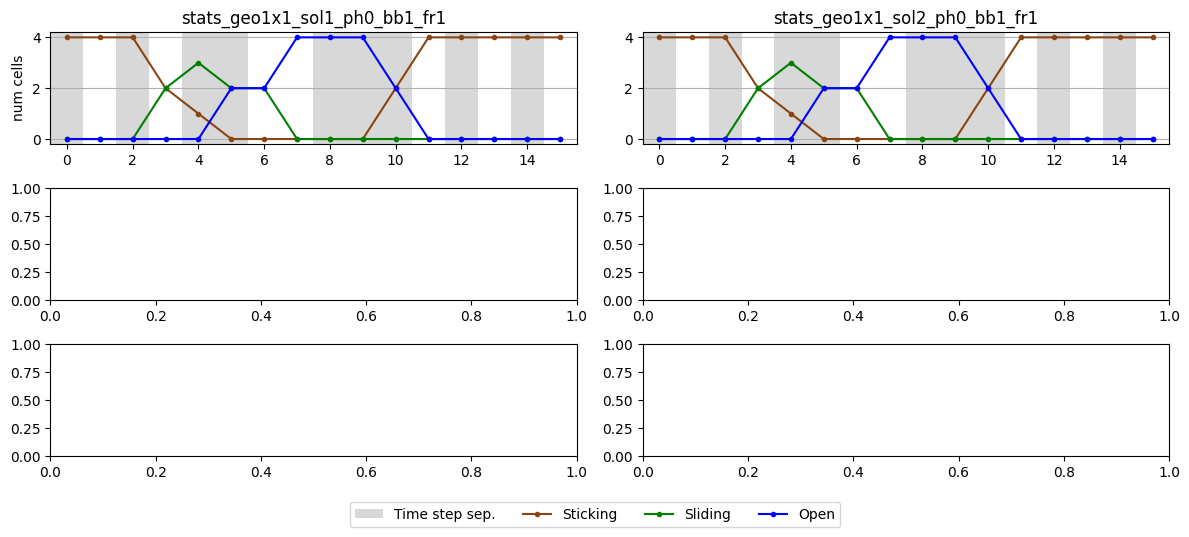

In [26]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which='major', axis='y')
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(data, render_element, shape=shape, figsize=figsize, 
        #   ylabel="Fract. len., m"
        ylabel='num cells'
          )
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

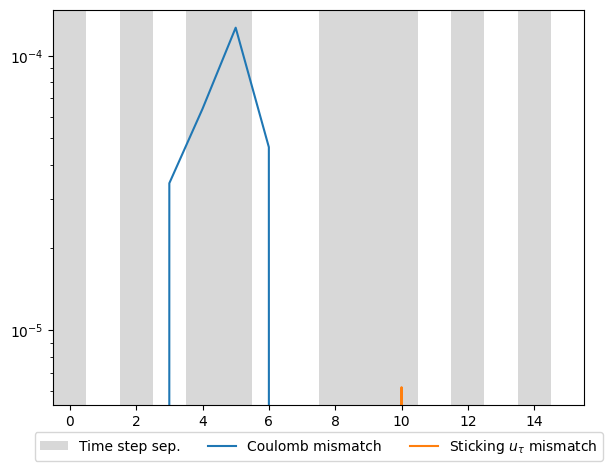

In [27]:
x = data['stats_geo1x1_sol2_ph0_bb1_fr1']
coulomb_mismatch = [ls.coulomb_mismatch for ts in x for ls in ts.linear_solves]
sticking_ut = [ls.sticking_u_mismatch for ts in x for ls in ts.linear_solves]
lambdan_max = [ls.lambdan_max for ts in x for ls in ts.linear_solves]
lambdat_max = [ls.lambdat_max for ts in x for ls in ts.linear_solves]
ujumpn_max = [ls.un_max for ts in x for ls in ts.linear_solves]
ujumpt_max = [ls.ut_max for ts in x for ls in ts.linear_solves]

color_time_steps(x, fill=True, grid=False, legend=True)
plt.plot(coulomb_mismatch, label='Coulomb mismatch')
plt.plot(sticking_ut, label=r'Sticking $u_\tau$ mismatch')
# plt.plot(lambdan_max, label=r'$\lambda_n$ max')
# plt.plot(lambdat_max, label=r'$\lambda_\tau$ max')
# plt.plot(ujumpn_max, label=r'$u_n$ max')
# plt.plot(ujumpt_max, label=r'$u_\tau$ max')
plt.yscale('log')
plt.legend(

            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            ncol=5,
            fancybox=True,
        )
plt.tight_layout()
# plt.ylim(bottom=1e-6, top=1e-3)


stats_geo1x1_sol2_ph1_bb1_fr1

Sim time: 0, Dt: 0.5
sticking: 4, sliding: 0, open: 0


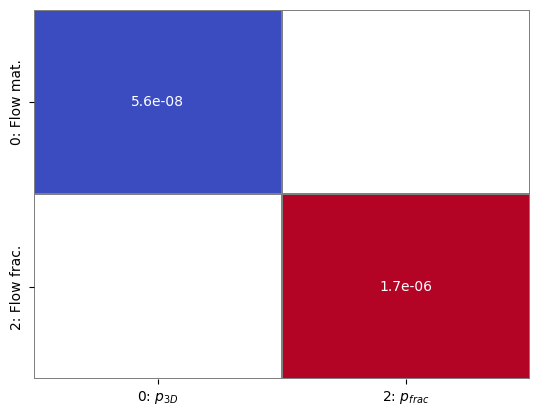

In [63]:
from mat_utils import *
from plot_utils import *
from block_matrix import *
from fixed_stress import *
from pp_utils import build_mechanics_near_null_space
from tmp_model import make_model, setup

model = make_model(setup)
model.prepare_simulation()
print(model.simulation_name())
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

J = model.bmat.copy()
rhs = model.linear_system[1]
# J.matshow_blocks()

J = model.bmat
J[[0,2]].plot_max()

Solve  took: 0.0
True residual decrease: 1.4330597047818138e-09
PETSc Converged Reason: 2


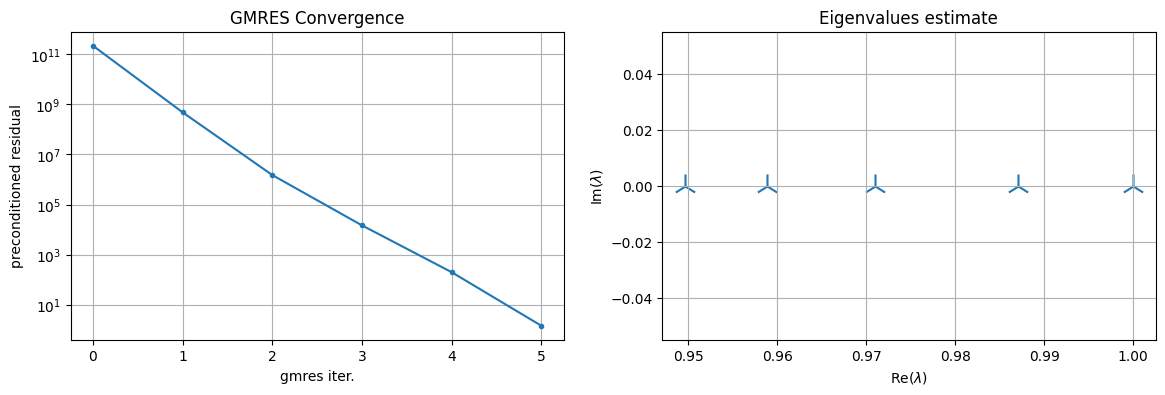

In [36]:
idx = [0, 2]
prec = PetscAMGFlow(mat=J[idx].mat)
rhs = np.ones(J[idx].shape[0])
solve_petsc(J[idx].mat, prec, rhs=J[idx].local_rhs(rhs))

Solve  took: 0.0
True residual permuted: 7.94797155593292e-15
PETSc Converged Reason: 2


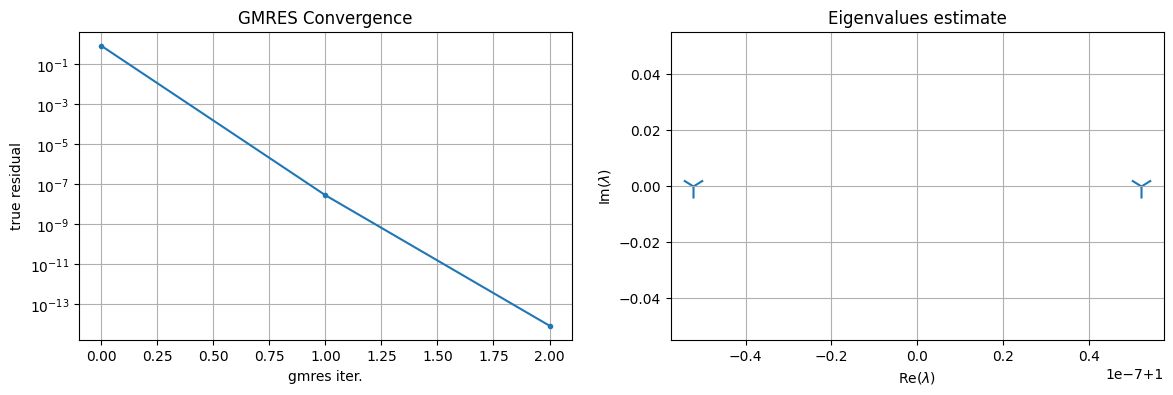

In [65]:



schema = SolveSchema(
    # # Exactly eliminate contact mechanics (assuming linearly-transformed system)
    # groups=[4],
    # solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # complement=SolveSchema(
    #     # Eliminate interface flow, it is not coupled with (1, 4, 5)
    #     # Use diag() to approximate inverse and ILU to solve linear systems
    #     groups=[3],
    #     solve=lambda bmat: PetscILU(bmat[[3]].mat),
    #     invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    #     complement=SolveSchema(
            # Eliminate elasticity. Use AMG to solve linear systems and fixed
            # stress to approximate inverse.
            groups=[1, 5],
            # solve=lambda bmat: PetscAMGMechanics(
            #     mat=bmat[[1, 5]].mat,
            #     dim=model.nd,
            #     null_space=build_mechanics_near_null_space(model),
            # ),
            invertor_type="physical",
            invertor=lambda bmat: make_fs_analytical(model, bmat).mat,
            # only_complement=True,
            complement=SolveSchema(
                # Use AMG to solve mass balance.
                groups=[0, 2],
                # solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        # ),
    # ),
)

# rhs = np.ones_like(rhs)

res = solve_petsc_new(
    J[[0,2,1,5]],
    schema,
    rhs_global=rhs,
    # Qright=model.Qright(),
    pc_side="right",
    tol=1e-10,
    # restrict_indices=[0,2]
)